In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import numpy as np
import pandas as pd
import joblib
import cv2
import itertools
import dask

from dask.distributed import Client
from tqdm.auto import tqdm
from ruamel.yaml import YAML
from copy import deepcopy
from scipy.optimize import linear_sum_assignment
from mouse_rt.proc.util import process_frame, apply_roi
from mouse_rt.util import select_strel

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [4]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [5]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
figure_cfg = analysis_config["figures"]
dask_address = analysis_config["dask"].get("address")

# Functions

In [6]:
# setup some simple pre-processing to simulate what we do online
def online_frame_process(frame, background, roi, clean_params):

    dframe = frame.copy()
    dframe = background - dframe
    dframe = apply_roi(dframe, **roi)
    dframe *= np.logical_and(
        dframe > clean_params["min_height_raw"], dframe < clean_params["max_height_raw"]
    )
    clean_params.pop("min_height_raw")
    clean_params.pop("max_height_raw")
    dframe = dframe.astype("uint8")
    proc_frame, features = process_frame(dframe, **clean_params)

    return dframe, proc_frame, features


def get_pc_scores(frames, pc_components):
    return frames.reshape(len(frames), -1).dot(pc_components.T)


def get_whitening_matrix(pca_scores, npcs=10, center=True):
    valid_scores = np.concatenate(
        [x[~np.isnan(x).any(axis=1), :npcs] for x in pca_scores.values()]
    )
    mu, cov = valid_scores.mean(axis=0), np.cov(valid_scores, rowvar=False, bias=1)
    L = np.linalg.cholesky(cov)

    return L, mu, cov


def relabel(labels1, labels2):

    set1 = set(labels1)
    set2 = set(labels2)

    all_labels = sorted(list(set1.union(set2)))
    max_label = max(all_labels) + 1

    cnt = np.zeros((max_label, max_label), dtype="float32")

    for r, c in zip(labels1, labels2):
        cnt[r, c] -= 1

    rows, cols = linear_sum_assignment(cnt)
    new_labels2 = deepcopy(labels2)

    for r, c in zip(rows, cols):
        new_labels2[labels2 == c] = r

    return new_labels2


def make_rot_mtx(center=(40, 40), angle=0, scale=(1, 1)):

    scale_x, scale_y = scale
    x, y = center

    alpha1 = np.cos(np.deg2rad(angle)) * scale_x
    alpha2 = np.cos(np.deg2rad(angle)) * scale_y
    beta1 = np.sin(np.deg2rad(angle)) * scale_y
    beta2 = np.sin(np.deg2rad(angle)) * scale_x

    return np.array(
        [
            [alpha1, beta1, (1 - alpha1) * x - (beta1 * y)],
            [-beta2, alpha2, beta2 * x + (1 - alpha2) * y],
        ]
    )


def jitter_frames(
    frames,
    jitter_position=(0, 0),
    jitter_scale=(1, 1, 1),
    jitter_rotation=0,
    jitter_skew=0,
    jitter_flip=False,
    jitter_pixel=3,
    jitter_rectify=True,
):

    dtype = frames.dtype
    use_frames = frames.copy().astype("float")
    ndims = len(frames.shape)

    if ndims > 2:
        rows, columns = frames.shape[1:]
    else:
        rows = 1
        columns = frames.shape[1]

    if jitter_flip:
        jitter_rotation += np.random.choice([180, -180], 1)

    use_frames *= jitter_scale[2]

    for i, frame in enumerate(use_frames):

        # roll dice for position, scale, rotation and flip
        xpos, ypos = jitter_position
        rot_mat = make_rot_mtx(
            (rows // 2, columns // 2), jitter_rotation, jitter_scale[:2]
        )
        rot_mat[0, -1] += jitter_position[0]
        rot_mat[1, -1] += jitter_position[1]
        frame = cv2.warpAffine(frame, rot_mat, (rows, columns))
        frame += np.random.randn(rows, columns) * jitter_pixel

        # prevent weirdness due to negative values
        if jitter_rectify:
            frame[frame < 0] = 0
        use_frames[i] = frame

    return use_frames.astype(dtype)

In [7]:
def load_realtime_package(realtime_dir):

    yaml = YAML(typ="rt")

    with open(os.path.join(realtime_dir, "metadata.yaml"), "r") as f:
        inf = dict(yaml.load(f.read()))["mouse-rt-arhmm"]

    load_paths = inf["paths"]

    rpackage = {
        #         'autoencoder': load_model(os.path.join(realtime_dir, load_paths["autoencoder"])),
        "arhmm": joblib.load(os.path.join(realtime_dir, load_paths["arhmm"]))["model"],
        "preprocessor": joblib.load(
            os.path.join(realtime_dir, load_paths["preprocessor"])
        ),
    }

    npcs = rpackage["arhmm"].obs_distns[0].D_out
    with h5py.File(os.path.join(realtime_dir, load_paths["pc_components"]), "r") as f:
        rpackage["pc_components"] = f["/components"][:npcs]

    return rpackage

In [8]:
def autoencode_frames_and_predict(
    rtime_dir, encode_frames, model_filename="autoencoder.h5"
):
    # from keras.models import load_model
    from tensorflow.keras.models import load_model
    import tensorflow as tf

    rpack = load_realtime_package(rtime_dir)
    use_frames = {}

    with tf.Session() as sess:
        mdl = load_model(os.path.join(rtime_dir, model_filename))
        use_frames["ae"] = mdl.predict(encode_frames[..., None]).squeeze()

    use_frames["raw"] = encode_frames
    labels = {}
    pcs = {}
    for k, v in use_frames.items():
        tmp = v.reshape(len(v), -1).dot(rpack["pc_components"].T)
        pcs[k] = rpack["preprocessor"].transform(tmp)
        labels[k] = rpack["arhmm"].heldout_viterbi(pcs[k])

    return labels, use_frames, pcs

# Load data and set parameters

In [9]:
tailfilter = select_strel("e", (9, 9))
clean_params = {
    "tailfilter": tailfilter
}

In [10]:
use_data = os.path.join(raw_dirs["misc"], "autoencoder_test_data.h5")
with h5py.File(use_data, "r") as f:
    use_frames = f["/frames"][()]
frames = {}
frames["offline"] = use_frames

In [11]:
# need to reference local packaage
realtime_package = raw_dirs["realtime_package"]

In [12]:
# set up the exponential filter over pixels (we also do this online)
fps = 30.0
tau = 0.035
sample_period = 1 / fps
smoothing_alpha = np.clip(sample_period / tau, 0, 1)

# Jitter and compute labels

## Scale

In [13]:
new_dcts = []

In [14]:
npcs = 10
frame_range = range(2000)

In [15]:
scale_steps = np.linspace(0.1, 2.5, 80)
scale_steps = np.insert(scale_steps, 0, 1)

In [16]:
if dask_address is not None:
    import dask.delayed as use_delayed
    client = Client(dask_address)
    def process_delays(delays):
        futures = client.compute(delays)
        return client.gather(futures)
else:
    import joblib.delayed as use_delayed
    from joblib import Parallel
    def process_delays(delays):
        return Parallel(n_jobs=2, verbose=10, backend="multiprocessing")(delays)

In [18]:
# for each step collect both raw and autoencoded
delays = []
results = []
for step in tqdm(scale_steps):
    tmp = jitter_frames(
        frames["offline"][frame_range],
        jitter_position=(0, 0),
        jitter_rotation=0,
        jitter_pixel=0,
        jitter_scale=(step, step, step),
    )
    delays.append(use_delayed(autoencode_frames_and_predict)(realtime_package, tmp))

  0%|          | 0/81 [00:00<?, ?it/s]

In [19]:
results = process_delays(delays)

/home/markowitzmeister_gmail_com/miniconda3/envs/mouse-rt-simulate-gpu/lib/python3.7/site-packages/distributed/worker.py:4504: UserWarning: Large object of size 12.21 MiB detected in task graph: 
  ('/home/markowitzmeister_gmail_com/jeff_win_share/ ... , dtype=uint8))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [20]:
baseline_labels, baseline_frames, baseline_pcs = results[0]
for i, (scale, (_labels, _frames, _pcs)) in enumerate(
    zip(scale_steps[1:], results[1:])
):
    for k in _labels.keys():
        dct = {
            "label match": (baseline_labels[k] == _labels[k]).mean(),
            "frame mse": ((baseline_frames[k] - _frames[k]) ** 2).mean(),
            "pc mse": ((baseline_pcs[k][:, :npcs] - _pcs[k][:, :npcs]) ** 2).mean(),
            "jitter value": scale,
            "type": k,
            "jitter type": "scale",
        }
        new_dcts.append(dct)

## Skew (x)

In [21]:
scale_steps = np.linspace(0.1, 2.5, 80)
scale_steps = np.insert(scale_steps, 0, 1)

In [22]:
# for each step collect both raw and autoencoded
delays = []
for step in tqdm(scale_steps):
    tmp = jitter_frames(
        frames["offline"][frame_range],
        jitter_position=(0, 0),
        jitter_rotation=0,
        jitter_pixel=0,
        jitter_scale=(step, 1, 1),
    )
    delays.append(use_delayed(autoencode_frames_and_predict)(realtime_package, tmp))

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
results = process_delays(delays)

In [24]:
baseline_labels, baseline_frames, baseline_pcs = results[0]
for i, (scale, (_labels, _frames, _pcs)) in enumerate(
    zip(scale_steps[1:], results[1:])
):
    for k in _labels.keys():
        dct = {
            "label match": (baseline_labels[k] == _labels[k]).mean(),
            "frame mse": ((baseline_frames[k] - _frames[k]) ** 2).mean(),
            "pc mse": ((baseline_pcs[k][:, :npcs] - _pcs[k][:, :npcs]) ** 2).mean(),
            "jitter value": scale,
            "type": k,
            "jitter type": "skew (x)",
        }
        new_dcts.append(dct)

## Skew (y)

In [25]:
scale_steps = np.linspace(0.1, 2.5, 80)
scale_steps = np.insert(scale_steps, 0, 1)

In [26]:
# for each step collect both raw and autoencoded
delays = []
for step in tqdm(scale_steps):
    tmp = jitter_frames(
        frames["offline"][frame_range],
        jitter_position=(0, 0),
        jitter_rotation=0,
        jitter_pixel=0,
        jitter_scale=(1, step, 1),
    )
    delays.append(use_delayed(autoencode_frames_and_predict)(realtime_package, tmp))

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
results = process_delays(delays)

In [28]:
baseline_labels, baseline_frames, baseline_pcs = results[0]
for i, (scale, (_labels, _frames, _pcs)) in enumerate(
    zip(scale_steps[1:], results[1:])
):
    for k in _labels.keys():
        dct = {
            "label match": (baseline_labels[k] == _labels[k]).mean(),
            "frame mse": ((baseline_frames[k] - _frames[k]) ** 2).mean(),
            "pc mse": ((baseline_pcs[k][:, :npcs] - _pcs[k][:, :npcs]) ** 2).mean(),
            "jitter value": scale,
            "type": k,
            "jitter type": "skew (y)",
        }
        new_dcts.append(dct)

## Skew (z)

In [29]:
scale_steps = np.linspace(0.1, 2.5, 80)
scale_steps = np.insert(scale_steps, 0, 1)

In [30]:
# for each step collect both raw and autoencoded
delays = []
for step in tqdm(scale_steps):
    tmp = jitter_frames(
        frames["offline"][frame_range],
        jitter_position=(0, 0),
        jitter_rotation=0,
        jitter_pixel=0,
        jitter_scale=(1, 1, step),
    )
    delays.append(use_delayed(autoencode_frames_and_predict)(realtime_package, tmp))

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
results = process_delays(delays)

In [32]:
baseline_labels, baseline_frames, baseline_pcs = results[0]
for i, (scale, (_labels, _frames, _pcs)) in enumerate(
    zip(scale_steps[1:], results[1:])
):
    for k in _labels.keys():
        dct = {
            "label match": (baseline_labels[k] == _labels[k]).mean(),
            "frame mse": ((baseline_frames[k] - _frames[k]) ** 2).mean(),
            "pc mse": ((baseline_pcs[k][:, :npcs] - _pcs[k][:, :npcs]) ** 2).mean(),
            "jitter value": scale,
            "type": k,
            "jitter type": "skew (z)",
        }
        new_dcts.append(dct)

## Rotation

In [33]:
scale_steps = np.linspace(-40, 40, 40)
scale_steps = np.insert(scale_steps, 0, 0)

In [34]:
# for each step collect both raw and autoencoded
delays = []
for step in tqdm(scale_steps):
    tmp = jitter_frames(
        frames["offline"][frame_range],
        jitter_position=(0, 0),
        jitter_rotation=step,
        jitter_pixel=0,
        jitter_scale=(1, 1, 1),
    )
    delays.append(use_delayed(autoencode_frames_and_predict)(realtime_package, tmp))

  0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
results = process_delays(delays)

In [36]:
baseline_labels, baseline_frames, baseline_pcs = results[0]
for i, (scale, (_labels, _frames, _pcs)) in enumerate(
    zip(scale_steps[1:], results[1:])
):
    for k in _labels.keys():
        dct = {
            "label match": (baseline_labels[k] == _labels[k]).mean(),
            "frame mse": ((baseline_frames[k] - _frames[k]) ** 2).mean(),
            "pc mse": ((baseline_pcs[k][:, :npcs] - _pcs[k][:, :npcs]) ** 2).mean(),
            "jitter value": scale,
            "type": k,
            "jitter type": "rotation",
        }
        new_dcts.append(dct)

## Pixel noise

In [37]:
scale_steps = np.linspace(0, 20, 21)

In [38]:
# for each step collect both raw and autoencoded
delays = []
for step in tqdm(scale_steps):
    tmp = jitter_frames(
        frames["offline"][frame_range],
        jitter_position=(0, 0),
        jitter_rotation=0,
        jitter_pixel=step,
        jitter_scale=(1, 1, 1),
    )
    delays.append(use_delayed(autoencode_frames_and_predict)(realtime_package, tmp))

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
results = process_delays(delays)

In [40]:
baseline_labels, baseline_frames, baseline_pcs = results[0]
for i, (scale, (_labels, _frames, _pcs)) in enumerate(
    zip(scale_steps[1:], results[1:])
):
    for k in _labels.keys():
        dct = {
            "label match": (baseline_labels[k] == _labels[k]).mean(),
            "frame mse": ((baseline_frames[k] - _frames[k]) ** 2).mean(),
            "pc mse": ((baseline_pcs[k][:, :npcs] - _pcs[k][:, :npcs]) ** 2).mean(),
            "jitter value": scale,
            "type": k,
            "jitter type": "pixel noise",
        }
        new_dcts.append(dct)

## Position jitter (x and y)

In [41]:
scale_steps = np.linspace(-8, 8, 17)
scale_steps = list(itertools.product(scale_steps, scale_steps))

In [42]:
# for each step collect both raw and autoencoded
delays = []
for (step_x, step_y) in tqdm(scale_steps):
    tmp = jitter_frames(
        frames["offline"][frame_range],
        jitter_position=(step_x, step_y),
        jitter_rotation=0,
        jitter_pixel=0,
        jitter_scale=(1, 1, 1),
    )
    delays.append(use_delayed(autoencode_frames_and_predict)(realtime_package, tmp))

  0%|          | 0/289 [00:00<?, ?it/s]

In [ ]:
results = process_delays(delays)

In [44]:
baseline_labels, baseline_frames, baseline_pcs = results[
    np.where([_ == (0, 0) for _ in scale_steps])[0][0]
]
for i, ((scale_x, scale_y), (_labels, _frames, _pcs)) in enumerate(
    zip(scale_steps, results)
):
    for k, v in _labels.items():
        dct = {
            "label match": (baseline_labels[k] == _labels[k]).mean(),
            "frame mse": ((baseline_frames[k] - _frames[k]) ** 2).mean(),
            "pc mse": ((baseline_pcs[k][:, :npcs] - _pcs[k][:, :npcs]) ** 2).mean(),
            "jitter value": scale_x,
            "jitter value 2": scale_y,
            "type": k,
            "jitter type": "jitter",
        }
        new_dcts.append(dct)

In [45]:
df = pd.DataFrame(new_dcts)

In [46]:
df.head()

,label match,frame mse,pc mse,jitter value,type,jitter type,jitter value 2
0,0.0,37.905605,3.488390,0.100000,ae,scale,NaN
1,0.0,10.427104,12.436630,0.100000,raw,scale,NaN
2,0.0,40.088398,3.808555,0.130380,ae,scale,NaN
3,0.0,10.420596,12.437124,0.130380,raw,scale,NaN
4,0.0,44.146496,4.473102,0.160759,ae,scale,NaN


In [47]:
# make a heatmap

In [48]:
client.close()
# cluster.close()

In [50]:
df.to_parquet(
    os.path.join(
        proc_dirs["misc"], "autoencoder_characterization.parquet"
    )
)

# Load in processed results and plot

In [51]:
df = pd.read_parquet(
    os.path.join(
        proc_dirs["misc"], "autoencoder_characterization.parquet"
    )
)

In [52]:
df["label match"] = 1 - df["label match"]

In [53]:
_tmp = df.melt(id_vars=["type", "jitter type", "jitter value", "jitter value 2"])

In [54]:
_tmp["variable"].unique()

array(['label match', 'frame mse', 'pc mse'], dtype=object)

In [55]:
fig_dct = {
    "font.size": 7,
    "axes.titlesize": 7,
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
}

/home/markowitzmeister_gmail_com/miniconda3/envs/mouse-rt-simulate-gpu/lib/python3.7/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/mouse-rt-simulate-gpu/lib/python3.7/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/mouse-rt-simulate-gpu/lib/python3.7/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/markowitzmeister_gmail_com/miniconda3/envs/mouse-rt-simulate-gpu/lib/python3.7/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


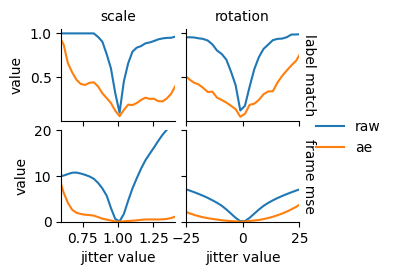

In [58]:
g = sns.FacetGrid(
    data=_tmp,
    col="jitter type",
    col_order=[
        "scale",
        "rotation",
    ],
    row="variable",
    row_order=["label match", "frame mse"],
    sharey="row",
    margin_titles=True,
    sharex="col",
    gridspec_kws={"wspace": 0.1, "hspace": 0.1},
)
g.map(
    sns.lineplot,
    "jitter value",
    "value",
    "type",
    ci=None,
    hue_order=["raw", "ae"],
    estimator=np.nanmean,
    #         palette=colors_syllables,
)
for ax in g.axes.flat:
    plt.setp(ax.texts, text="")
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.fig.set_size_inches(3, 2.5)
g.add_legend()
for ax in g.axes[0]:
    if ax.get_title() != "rotation":
        ax.set_xlim(0.6, 1.4)
    else:
        ax.set_xlim(-25, 25)
for ax in g.axes[1]:
    ax.set_ylim(0, 20)
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "ae_scale_rotation_profile"),
    bbox_inches="tight",
)

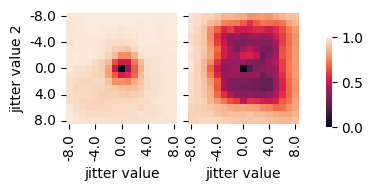

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(3, 3), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.99, 0.3, 0.02, 0.3])
sns.heatmap(
    data=df[(df["jitter type"] == "jitter") & (df["type"] == "raw")].pivot_table(
        index="jitter value 2", columns="jitter value", values="label match"
    ),
    vmin=0,
    vmax=1,
    ax=ax[0],
    xticklabels=4,
    yticklabels=4,
    cbar=True,
    square=True,
    rasterized=True,
    cbar_ax=cbar_ax,
)
sns.heatmap(
    data=df[(df["jitter type"] == "jitter") & (df["type"] == "ae")].pivot_table(
        index="jitter value 2", columns="jitter value", values="label match"
    ),
    vmin=0,
    cbar=False,
    cbar_ax=None,
    xticklabels=4,
    yticklabels=4,
    square=True,
    rasterized=True,
    vmax=1,
    ax=ax[1],
)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[1].set_ylabel("")

# ax[0].set_box_aspect(1)
# ax[1].set_box_aspect(1)


# ax[1].set_yticks([])
fig.subplots_adjust(wspace=0.1)
# ax[0].axis("equal")

plt.show()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "ae_robustness_position_label_match"),
    bbox_inches="tight",
)

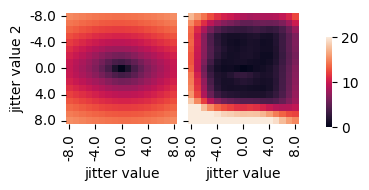

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(3, 3), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.99, 0.3, 0.02, 0.3])
im = sns.heatmap(
    data=df[(df["jitter type"] == "jitter") & (df["type"] == "raw")].pivot_table(
        index="jitter value 2", columns="jitter value", values="frame mse"
    ),
    vmin=0,
    vmax=20,
    ax=ax[0],
    xticklabels=4,
    yticklabels=4,
    square=True,
    rasterized=True,
    cbar=True,
    cbar_ax=cbar_ax,
)
sns.heatmap(
    data=df[(df["jitter type"] == "jitter") & (df["type"] == "ae")].pivot_table(
        index="jitter value 2", columns="jitter value", values="frame mse"
    ),
    vmin=0,
    cbar=False,
    cbar_ax=None,
    xticklabels=4,
    yticklabels=4,
    square=True,
    rasterized=True,
    vmax=20,
    ax=ax[1],
)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[1].set_ylabel("")
# ticks = [-8, 0, 8]

# ax[0].set_box_aspect(1)
# ax[1].set_box_aspect(1)

fig.subplots_adjust(wspace=0.1)
# ax[0].axis("equal")
plt.show()

savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "ae_robustness_position_frame_mse"),
    bbox_inches="tight",
)